# 实验三: EigenFace 方法人脸识别系统设计

朱云沁 PB20061372


## Introduction

EigenFace is a face recognition algorithm that utilizes Principal Component Analysis (PCA) and K-Nearest Neighbors (KNN) classification to identify and classify human faces. To build a face recognition system, we first obtain a collection of face images representing a set of individuals and then preprocess the images to ensure consistent features, such as alignment, grayscale conversion, and normalization. Next, we apply PCA to reduce the dimensionality and extract the most important facial features. Finally, we apply KNN classification to identify new faces based on their proximity to known faces in the feature space.

### Principal Component Analysis

The goal of PCA is to find a set of orthogonal vectors known as eigenfaces or principal components that capture the maximum variance in the face images. Given a face image dataset $\mathbf{X} \in \mathbb{R}^{n \times d} = (\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n)^\top$, where $n$ is the number of images and $d$ is the dimensionality of each image after vectorization (the number of pixels), we first compute the mean face and then subtract it from each image in the dataset to obtain the mean-centered dataset $\mathbf{\tilde{X}}$:

$$
\mathbf{\tilde{X}} = \mathbf{X} - \frac{1}{n} \sum_{i=1}^{n} \mathbf{x}_i^\top
$$

Note that we have broadcasted the mean face to each row of $\mathbf{X}$. Basically, the principal components are the singular vectors of the centered data matrix $\mathbf{\tilde{X}}$ that correspond to the $k$ largest singular values, where $k$ is a hyperparameter that we can tune.
Therefore, what is left is to compute the truncated SVD $\mathbf{\tilde{X}} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top = \sum_{i=1}^{n} \sigma_i \mathbf{u}_i \mathbf{v}_i^\top \approx \sum_{i=1}^{k} \sigma_i \mathbf{u}_i \mathbf{v}_i^\top$, where $\sigma_i$ and $\mathbf{v}_i$ are the $i$-th singular value and eigenface, respectively. 

Another equivalent formulation of PCA is to compute the eigenvalue decomposition of the covariance matrix $\mathbf{S} = \frac{1}{n-1} \mathbf{\tilde{X}}^\top \mathbf{\tilde{X}} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^\top$, where the columns of $\mathbf{V}$ are the eigenfaces, and the eigenvalues represent the variance captured by each eigenface.

Denote $\mathbf{V}_k = (\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_k)$ as the matrix of the first $k$ eigenfaces. We project the centered data matrix $\mathbf{\tilde{X}}$ to the eigenspace as $\mathbf{Z} = \mathbf{\tilde{X}} \mathbf{V}_k$, and then use it as the input features for some subsequent classification algorithm, such as KNN.

Actually, we can reconstruct the original data matrix as $\mathbf{Y} = \mathbf{Z} \mathbf{V}_k^\top$, which is the optimal solution to the following optimization problem:

$$
\begin{aligned}
\min_{\mathbf{Y}} \quad & \|\mathbf{\tilde{X}} - \mathbf{Y}\|_F^2 \\
\text{s.t.} \quad & \mathrm{rank}(\mathbf{Y}) \leq k
\end{aligned}
$$

That is, $\mathbf{\tilde{X}} \mathbf{V}_k \mathbf{V}_k^\top$ is the best rank-$k$ approximation of $\mathbf{\tilde{X}}$ in terms of the Frobenius norm.

### $k$-Nearest Neighbors

The KNN algorithm follows a simple and intuitive approach. The classification of a new, unlabeled face image is determined by examining its proximity to the labeled face images in the feature space. To be specific, given a new face image $\mathbf{x}$, we find the $k$ nearest neighbors of $\mathbf{z} = \mathbf{V}_k^\top (\mathbf{x} - \frac{1}{n} \sum_{i=1}^{n} \mathbf{x}_i)$ in the rows of $\mathbf{Z}$ by the Euclidean distance. The class of $\mathbf{x}$ is then determined by the majority vote of the classes of its $k$ nearest neighbors.

## Experiment

### Initialization

In [191]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split


np.random.seed(42)

### Dataset

Load images and labels:

In [192]:
DATA_DIR = 'images'

images = []
labels = []
dirs = os.listdir(DATA_DIR)
dirs = sorted((d for d in dirs if d.startswith('s')), key=lambda s: int(s[1:]))
for d in dirs:
    files = os.listdir(os.path.join(DATA_DIR, d))
    files = sorted((f for f in files if f.endswith('.pgm')), key=lambda s: int(s[:-4]))
    images += [plt.imread(os.path.join(DATA_DIR, d, f)) for f in files]
    labels += [int(d[1:])] * len(files)

images = np.array(images)
labels = np.array(labels)
unique_labels, unique_counts = np.unique(labels, return_counts=True)
print(f'{len(images)} images with {images.shape[1]}x{images.shape[2]} pixels')
print(f'{len(unique_labels)} unique labels')

400 images with 112x92 pixels
40 unique labels


Display sample images:

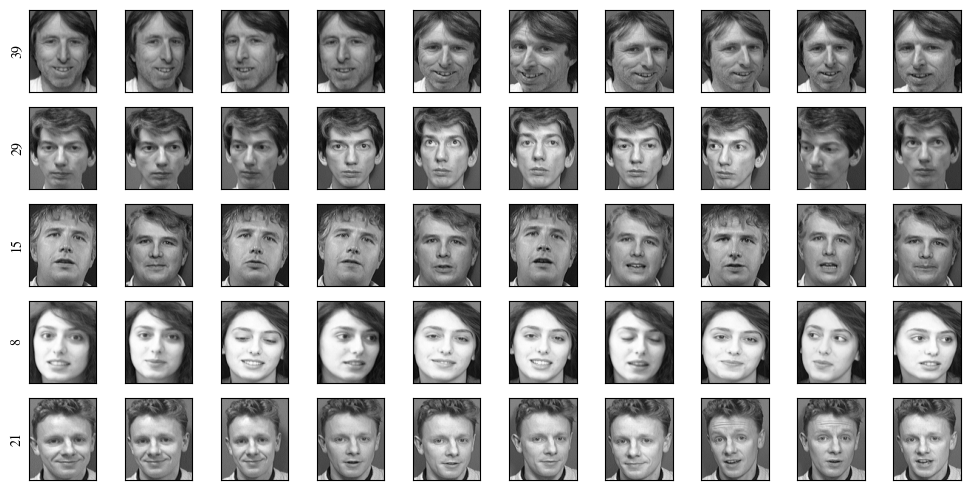

In [193]:
num_rows = 5
idx = np.random.randint(0, len(unique_labels), size=num_rows)
sample_labels = unique_labels[idx]
sample_counts = unique_counts[idx]
num_cols = max(sample_counts)

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(num_cols, num_rows),
    subplot_kw={'xticks': [], 'yticks': []},
)

for i in range(num_rows):
    indices = np.where(labels == sample_labels[i])[0]
    axes[i, 0].set_ylabel(sample_labels[i])
    for j in range(num_cols):
        if j >= sample_counts[i]:
            axes[i, j].axis('off')
            continue
        axes[i, j].imshow(images[indices[j]], cmap='gray')

plt.tight_layout()

Train-test split:

In [194]:
X = images.reshape(images.shape[0], -1) / 255
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'{X.shape=}, {y.shape=}')
print(f'{X_train.shape=}, {y_train.shape=}')
print(f'{X_test.shape=}, {y_test.shape=}')

X.shape=(400, 10304), y.shape=(400,)
X_train.shape=(320, 10304), y_train.shape=(320,)
X_test.shape=(80, 10304), y_test.shape=(80,)


### Implementation of PCA

In [195]:
class PCA:
    def __init__(self, k):
        self.k = k

    def fit(self, X):
        X = (X - X.mean(axis=0)) / np.sqrt(X.shape[0] - 1)
        _, self.S, Vt = np.linalg.svd(X, full_matrices=False)
        self.V = Vt.T
        return self

    def transform(self, X):
        return X @ self.V[:, : self.k]

    def fit_transform(self, X):
        return self.fit(X).transform(X)


k = 50
pca = PCA(k)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f'{X_train_pca.shape=}, {X_test_pca.shape=}')

X_train_pca.shape=(320, 50), X_test_pca.shape=(80, 50)


Visualize the principal components:

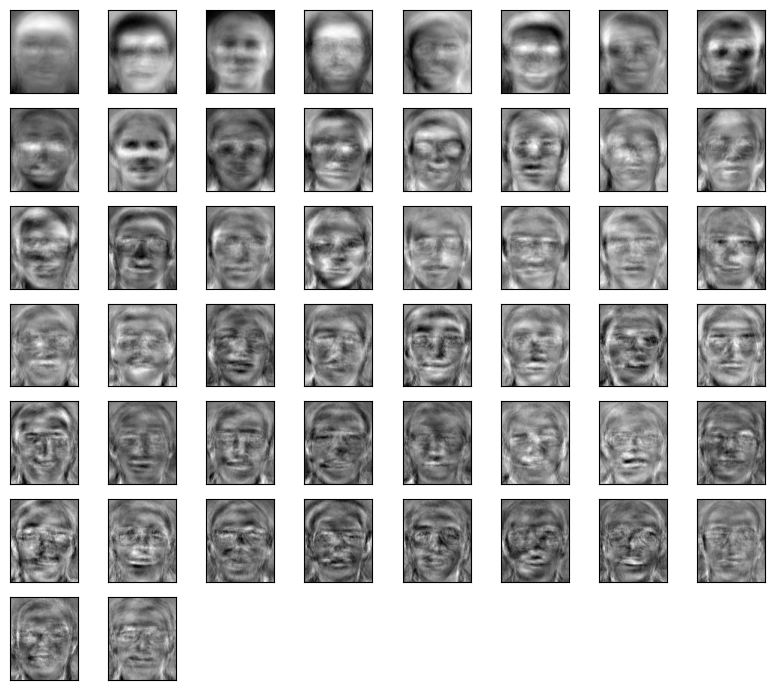

In [196]:
n_rows = np.sqrt(k).astype(int)
n_cols = np.ceil(k / n_rows).astype(int)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols, n_rows),
    subplot_kw={'xticks': [], 'yticks': []},
)
for i in range(n_rows):
    for j in range(n_cols):
        idx = i * n_cols + j
        if idx >= k:
            axes[i, j].axis('off')
            continue
        component = pca.V[:, idx].reshape(images.shape[1:])
        axes[i, j].imshow(component, cmap='gray')
plt.tight_layout()

Visualize the compressed images:

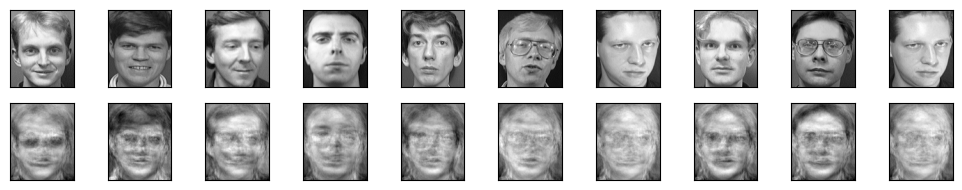

In [197]:
# Visualize the compressed images:
n_samples = 10
idx = np.random.randint(0, len(X_test), size=n_samples)
fig, axes = plt.subplots(
    2, n_samples, figsize=(n_samples, 2), subplot_kw={'xticks': [], 'yticks': []}
)
for i in range(n_samples):
    original = X_test[idx[i]].reshape(images.shape[1:])
    compressed = (X_test_pca[idx[i]] @ pca.V.T[: pca.k]).reshape(images.shape[1:])
    axes[0, i].imshow(original, cmap='gray')
    axes[1, i].imshow(compressed, cmap='gray')
plt.tight_layout()

Percentage of information preserved ($\frac{\sum_{i=1}^{k} \lambda_{i}}{\sum_{i=1}^{n} \lambda_{i}}$) vs. number of principal components ($k$):

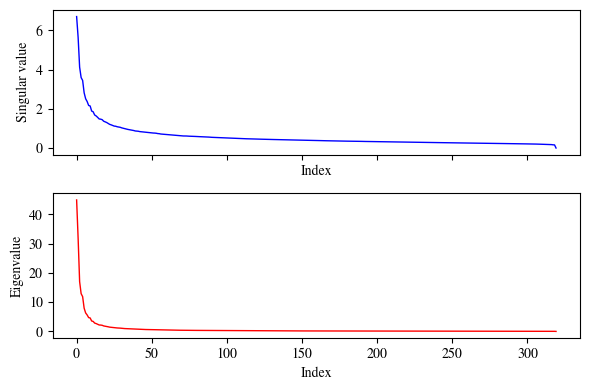

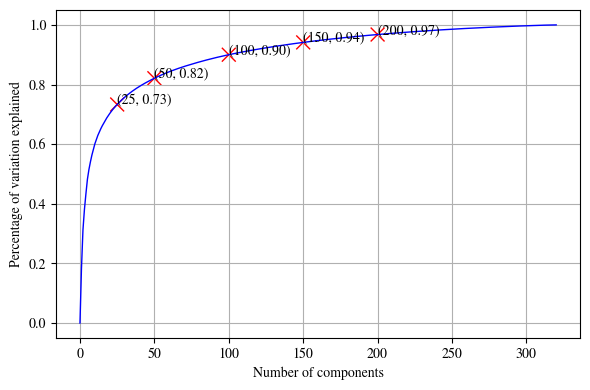

In [198]:
L = pca.S**2

# singular values & eigenvalues:
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
axes[0].plot(pca.S, c='b')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Singular value')
axes[1].plot(L, c='r')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Eigenvalue')
fig.tight_layout()

# cumulative percentage of variation explained:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.concatenate([[0], L.cumsum() / L.sum()]), c='b')
for k in [25, 50, 100, 150, 200]:
    ratio = L[:k].sum() / L.sum()
    ax.scatter(k, ratio, s=100, c='r', marker='x')
    ax.annotate(f'({k}, {ratio:.2f})', (k, ratio))
ax.set_xlabel('Number of components')
ax.set_ylabel('Percentage of variation explained')
ax.grid()
fig.tight_layout()

### Implementation of KNN

In [199]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        dists = np.sqrt(((X[:, np.newaxis] - self.X[np.newaxis]) ** 2).sum(axis=-1))
        idx = np.argpartition(dists, self.k, axis=-1)[:, : self.k]
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=-1, arr=self.y[idx]
        )

    def score(self, X, y):
        return (self.predict(X) == y).mean()


knn = KNN(k=1)
knn.fit(X_train_pca, y_train)
print(f'train_accuracy={knn.score(X_train_pca, y_train)}')
print(f'test_accuracy={knn.score(X_test_pca, y_test)}')

train_accuracy=1.0
test_accuracy=0.9875


### Putting Things Together

In [200]:
class EigenFace:
    def __init__(self, n_components, n_neighbors):
        self.pca = PCA(n_components)
        self.knn = KNN(n_neighbors)

    def fit(self, X, y):
        self.pca.fit(X)
        self.knn.fit(self.pca.transform(X), y)
        return self

    def predict(self, X):
        return self.knn.predict(self.pca.transform(X))

    def score(self, X, y):
        return self.knn.score(self.pca.transform(X), y)


def train_evaluate(n_components, n_neighbors):
    model = EigenFace(n_components, n_neighbors)
    model.fit(X_train, y_train)
    return (n_components, n_neighbors, model.score(X_test, y_test))

### Effect of number of principal components ($k$ in PCA)

  n_components    n_neighbors    accuracy
--------------  -------------  ----------
             1              1      0.1125
             2              1      0.3875
             3              1      0.6
             4              1      0.7375
             5              1      0.85
             6              1      0.8875
             7              1      0.9125
             8              1      0.9125
             9              1      0.9375
            10              1      0.9375
            11              1      0.9375
            12              1      0.9625
            13              1      0.9625
            14              1      0.975
            15              1      0.975
            16              1      0.975
            17              1      0.975
            18              1      0.975
            19              1      0.975
            20              1      0.975
            21              1      0.975
            22              1      0.975
      

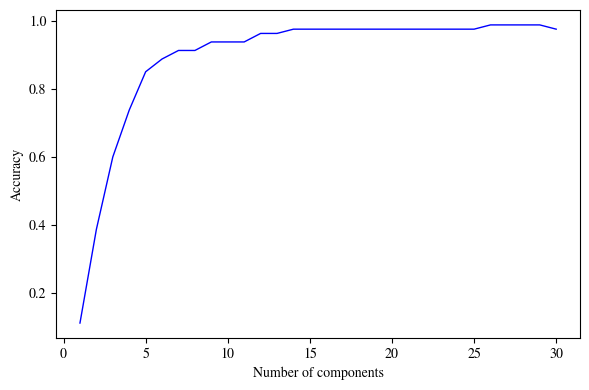

In [201]:
table = [train_evaluate(n_components, 1) for n_components in range(1, 31, 1)]
print(tabulate(table, headers=['n_components', 'n_neighbors', 'accuracy']))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot([row[0] for row in table], [row[2] for row in table], c='b')
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')
fig.tight_layout()

As the number of principal components increases and reaches the elbow point (around 25~30, see the figure of explained variance), we achieve an impressively high accuracy of 0.9875 on the test set.

### Effect of number of nearest neighbors ($k$ in KNN)

  n_components    n_neighbors    accuracy
--------------  -------------  ----------
            50              1      0.9875
            50              2      0.9375
            50              3      0.925
            50              4      0.95
            50              5      0.9375
            50              6      0.875
            50              7      0.8375
            50              8      0.825
            50              9      0.7875


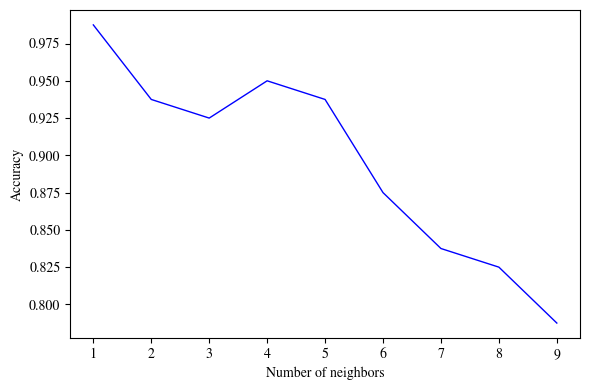

In [202]:
table = [train_evaluate(50, n_neighbors) for n_neighbors in range(1, 10, 1)]
print(tabulate(table, headers=['n_components', 'n_neighbors', 'accuracy']))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot([row[1] for row in table], [row[2] for row in table], c='b')
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Accuracy')
fig.tight_layout()

As the number of nearest neighbors increases, the accuracy on the test set decreases in general. The nearest neighbor classifier ($k=1$) achieves the highest accuracy of 0.9875.

## Conclusion

In this experiment, we have implemented the EigenFace algorithm for face recognition. As we can see, the performance of the algorithm is highly dependent on the number of principal components and the number of nearest neighbors.